<a href="https://colab.research.google.com/github/rebal-akar/MLCW2/blob/main/Fully_Supervised_ML%5BImproved%5D_CW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
    import torch
    import torchvision
    import sklearn
    import matplotlib
except ImportError:
    !pip install torch torchvision scikit-learn matplotlib tqdm

# Fully Supverised 2


✅ Cell 1 – Imports & Setup
python
Copy
Edit


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from tqdm import tqdm
import copy
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False



 Load Pretrained SimCLR Model for Selection
python
Copy


In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
from collections import OrderedDict

def load_pretrained_simclr_model(model_path, device):
    class SimCLRModel(nn.Module):
        def __init__(self):
            super(SimCLRModel, self).__init__()
            resnet = models.resnet18(pretrained=False)
            # Modify for CIFAR-10: use 3x3 conv and remove maxpool.
            resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            resnet.maxpool = nn.Identity()
            resnet.fc = nn.Identity()  # We'll only use the encoder part.
            self.encoder = resnet
            # Projection head is used only during pre-training.
            self.projector = nn.Sequential(
                nn.Linear(512, 512),
                nn.ReLU(),
                nn.Linear(512, 128)
            )

        def forward(self, x, return_embedding=False):
            h = self.encoder(x)
            h = torch.flatten(h, 1)
            if return_embedding:
                return h  # Use these embeddings for selection.
            return self.projector(h)

    simclr_model = SimCLRModel().to(device)
    checkpoint = torch.load(model_path, map_location=device)
    new_state_dict = OrderedDict()
    for key, value in checkpoint.items():
        if key.startswith("backbone."):
            new_key = "encoder." + key[len("backbone."):]
        elif key.startswith("contrastive_head."):
            new_key = "projector." + key[len("contrastive_head."):]
        else:
            new_key = key
        if "shortcut" in new_key:
            new_key = new_key.replace("shortcut", "downsample")
        new_state_dict[new_key] = value
    missing_keys, unexpected_keys = simclr_model.load_state_dict(new_state_dict, strict=False)
    print("Missing keys:", missing_keys)
    print("Unexpected keys:", unexpected_keys)
    simclr_model.eval()  # Freeze the SimCLR model for selection.
    print("✅ Pretrained SimCLR model loaded successfully!")
    return simclr_model

# Example usage:
simclr_ckpt_path = "/content/drive/MyDrive/Typiclust/simclr_cifar-10.pth"
simclr_model = load_pretrained_simclr_model(simclr_ckpt_path, device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Missing keys: []
Unexpected keys: []
✅ Pretrained SimCLR model loaded successfully!


Cell 2 – Data Preparation


In [3]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)


100%|██████████| 170M/170M [00:01<00:00, 85.3MB/s]


Cell 3 – ResNet18 Model for CIFAR-10



In [4]:
def get_resnet18_fully_supervised(num_classes=10):
    model = torchvision.models.resnet18(weights=None)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(512, num_classes)
    return model


Cell 4 – Active Learning Setup
python
Copy
Edit


✅ Cell 5 – Training, Evaluation, Embedding Extraction
python
Copy
Edit


In [5]:

max_clusters = 500




In [6]:
def train_model(model, train_loader, num_epochs=100):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            scheduler.step()
        if (epoch + 1) % 10 == 0:
            avg_loss = running_loss / len(train_loader.dataset)
            print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")
    return model

def evaluate_model(model, data_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

def extract_embeddings(model, loader):
    model.eval()
    feat_model = copy.deepcopy(model)
    feat_model.fc = nn.Identity()
    feat_model = feat_model.to(device)

    all_embeddings = []
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            feats = feat_model(images, return_embedding=True).cpu()
            norms = np.linalg.norm(feats, axis=1, keepdims=True) + 1e-8
            feats = feats / norms
            all_embeddings.append(feats.cpu().numpy())
    return np.concatenate(all_embeddings, axis=0)



✅ Cell 6 – TypiClust Selection
python
Copy
Edit


In [7]:
def compute_typicality_nn(cluster_features, K=20):
    """
    Compute typicality scores for a set of feature vectors.
    Typicality is defined as the inverse of the average distance
    (excluding self-distance) to K nearest neighbors.
    """
    n = cluster_features.shape[0]
    if n == 0:
        return np.array([])
    nbrs = NearestNeighbors(n_neighbors=min(K + 1, n), algorithm='auto', metric='euclidean').fit(cluster_features)
    distances, _ = nbrs.kneighbors(cluster_features)
    # Exclude the zero distance to self (first column)
    avg_distances = np.mean(distances[:, 1:], axis=1)
    typicality = 1.0 / (avg_distances + 1e-8)
    return typicality

def typiclust_pool_selection_batch(unlabeled_embeddings, unlabeled_ids, budget, max_clusters, labeled_embeddings, labeled_ids, min_cluster_size=5,random_state=None):
    """
    Select a batch of indices from the unlabeled pool using TypiClust.

    This function clusters the embeddings using KMeans or MiniBatchKMeans,
    then for clusters that have no labeled data and are large enough,
    selects the most "typical" sample based on the inverse of the average
    distance to its K nearest neighbors.

    Args:
        unlabeled_embeddings (np.ndarray): Embeddings for unlabeled data.
        unlabeled_ids (list): The corresponding original indices for unlabeled data.
        budget (int): Number of samples to select.
        max_clusters (int): Maximum number of clusters to form.
        labeled_embeddings (np.ndarray): Embeddings for already labeled data.
        labeled_ids (list): The indices of labeled data.
        min_cluster_size (int): Minimum number of unlabeled samples in a cluster to be considered.

    Returns:
        queries (list): List of selected sample indices from unlabeled_ids.
    """
    current_labeled_count = len(labeled_ids)
    n_clusters = min(current_labeled_count + budget, max_clusters)

    if current_labeled_count > 0:
        X_total = np.concatenate([unlabeled_embeddings, labeled_embeddings], axis=0)
        is_unlabeled = np.array([True] * unlabeled_embeddings.shape[0] + [False] * labeled_embeddings.shape[0])
    else:
        X_total = unlabeled_embeddings
        is_unlabeled = np.array([True] * unlabeled_embeddings.shape[0])

    if n_clusters > 50:
        clusterer = MiniBatchKMeans(n_clusters=n_clusters, random_state=random_state)
    else:
        clusterer = KMeans(n_clusters=n_clusters, random_state=random_state)
    cluster_labels = clusterer.fit_predict(X_total)

    # Gather cluster info: unlabeled indices and labeled count per cluster.
    cluster_stats = []
    for cluster in np.unique(cluster_labels):
        idxs = np.where(cluster_labels == cluster)[0]
        cluster_size = len(idxs)
        labeled_count = np.sum(~is_unlabeled[idxs])
        unlabeled_idxs = [i for i in idxs if is_unlabeled[i]]
        if len(unlabeled_idxs) >= min_cluster_size:
            cluster_stats.append({
                'cluster_id': cluster,
                'cluster_size': cluster_size,
                'labeled_count': labeled_count,
                'unlabeled_idx': unlabeled_idxs
            })

    if len(cluster_stats) == 0:
        return []

    # Convert to DataFrame for sorting.
    clusters_df = pd.DataFrame(cluster_stats)
    clusters_df = clusters_df.sort_values(by=['labeled_count', 'cluster_size'], ascending=[True, False])
    sorted_cluster_ids = clusters_df['cluster_id'].tolist()

    queries = []
    for i in range(budget):
        # Cycle through sorted cluster ids
        cluster_id = sorted_cluster_ids[i % len(sorted_cluster_ids)]
        row = clusters_df[clusters_df['cluster_id'] == cluster_id].iloc[0]
        candidate_indices = row['unlabeled_idx']
        if len(candidate_indices) == 0:
            continue
        candidate_embeddings = unlabeled_embeddings[candidate_indices]
        effective_K = min(20, candidate_embeddings.shape[0])
        typ_scores = compute_typicality_nn(candidate_embeddings, K=effective_K)
        best_local_idx = candidate_indices[np.argmax(typ_scores)]
        queries.append(unlabeled_ids[best_local_idx])
        # Remove the selected index from the candidate list
        updated_candidates = [idx for idx in candidate_indices if idx != best_local_idx]
        row_index = clusters_df.index[clusters_df['cluster_id'] == cluster_id][0]
        clusters_df.at[row_index, 'unlabeled_idx'] = updated_candidates

    return queries

def show_selected_images(dataset, selected_ids, num_to_show=20):
    """
    Visualize selected images from the dataset.
    """
    import matplotlib.pyplot as plt
    images_to_plot = selected_ids[:num_to_show]
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(images_to_plot):
        img, label = dataset[idx]
        img = img.permute(1, 2, 0).numpy()
        # Adjust image for display; adjust these values based on your normalization
        img = img * 0.2 + 0.5
        plt.subplot(1, num_to_show, i + 1)
        plt.imshow(np.clip(img, 0, 1))
        plt.axis('off')
        plt.title(f"{label}")
    plt.suptitle("TypiClust Selected Images")
    plt.show()


In [8]:
full_loader = DataLoader(train_dataset, batch_size=128, shuffle=False, num_workers=2)
simclr_full_embeddings = extract_embeddings(simclr_model, full_loader)
embedding_file = "saved_embeddings/simclr_cifar10_embeddings.npy"
os.makedirs("saved_embeddings", exist_ok=True)
np.save(embedding_file, simclr_full_embeddings)
print("Full embeddings saved with shape:", simclr_full_embeddings.shape)

<ipython-input-6-3d6d7d243f67>:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  feats = feats / norms


Full embeddings saved with shape: (50000, 512)


Hybrid TypiClust

In [9]:
def compute_least_confidence_resnet18(data_loader, model):
    """
    Compute uncertainty for candidate embeddings using least confidence.
    For each sample, uncertainty is defined as 1 - max(probabilities).
    """
    model.eval()
    uncertainties = []
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            max_probs, _ = torch.max(probs, dim=1)
            # Uncertainty is 1 - max probability
            uncertainties.extend((1 - max_probs).cpu().numpy())
    return np.array(uncertainties)


In [10]:
def hybrid_selection(unlabeled_embeddings, unlabeled_ids, budget, max_clusters, labeled_embeddings, labeled_ids, classifier, alpha=1.0):
    """
    Hybrid selection that combines typicality and uncertainty.
    For each candidate cluster (from KMeans clustering on the combined pool),
    compute typicality (as inverse average k-NN distance) and uncertainty (predictive entropy).
    Normalize the scores and combine them via:
      CombinedScore = alpha * norm_typicality + (1 - alpha) * norm_uncertainty.
    Then, select the candidate with the highest combined score from each cluster.

    If classifier is None (e.g. in the very first iteration), the method defaults to pure typicality.
    """
    # Determine number of clusters: K = min(|L| + budget, max_clusters)
    current_labeled_count = len(labeled_ids)
    n_clusters = min(current_labeled_count + budget, max_clusters)
    if current_labeled_count > 0:
        X_total = np.concatenate([unlabeled_embeddings, labeled_embeddings], axis=0)
        is_unlabeled = np.array([True] * unlabeled_embeddings.shape[0] + [False] * labeled_embeddings.shape[0])
    else:
        X_total = unlabeled_embeddings
        is_unlabeled = np.array([True] * unlabeled_embeddings.shape[0])

    # Choose clustering algorithm.
    if n_clusters > 50:
        clusterer = MiniBatchKMeans(n_clusters=n_clusters, random_state=None)
    else:
        clusterer = KMeans(n_clusters=n_clusters, random_state=None)
    cluster_labels = clusterer.fit_predict(X_total)

    # Build cluster statistics.
    cluster_stats = []
    min_cluster_size = 5
    for cluster in np.unique(cluster_labels):
        idxs = np.where(cluster_labels == cluster)[0]
        cluster_size = len(idxs)
        labeled_count = np.sum(~is_unlabeled[idxs])
        unlabeled_idxs = [i for i in idxs if is_unlabeled[i]]
        if len(unlabeled_idxs) >= min_cluster_size:
            cluster_stats.append({
                'cluster_id': cluster,
                'cluster_size': cluster_size,
                'labeled_count': labeled_count,
                'unlabeled_idx': unlabeled_idxs
            })
    if len(cluster_stats) == 0:
        return []
    clusters_df = pd.DataFrame(cluster_stats)
    clusters_df = clusters_df.sort_values(by=['labeled_count', 'cluster_size'], ascending=[True, False])
    sorted_cluster_ids = clusters_df['cluster_id'].tolist()

    queries = []
    for i in range(budget):
        # Cycle through clusters.
        cluster_id = sorted_cluster_ids[i % len(sorted_cluster_ids)]
        row = clusters_df[clusters_df['cluster_id'] == cluster_id].iloc[0]
        candidate_indices = row['unlabeled_idx']
        if len(candidate_indices) == 0:
            continue
        # Get candidate embeddings from the unlabeled pool.
        candidate_embeddings = unlabeled_embeddings[candidate_indices]
        knn = min(20, candidate_embeddings.shape[0])
        typ_scores = compute_typicality_nn(candidate_embeddings, K=knn)

        # If a classifier is provided, compute uncertainty; otherwise, use zeros.
        if classifier is not None:
            # Fetch raw images from dataset using unlabeled_ids
            candidate_dataset = Subset(train_dataset, [unlabeled_ids[i] for i in candidate_indices])
            candidate_loader = DataLoader(candidate_dataset, batch_size=64, shuffle=False)
            unc_scores = compute_least_confidence_resnet18(candidate_loader, classifier)
        else:
            unc_scores = np.zeros_like(typ_scores)

        # Normalize scores to [0,1].
        norm_typ = (typ_scores - np.min(typ_scores)) / (np.ptp(typ_scores) + 1e-8)
        norm_unc = (unc_scores - np.min(unc_scores)) / (np.ptp(unc_scores) + 1e-8)

        # Combined score: weight typicality with alpha and uncertainty with (1 - alpha).
        combined_score = alpha * norm_typ + (1 - alpha) * norm_unc
        best_local_idx = candidate_indices[np.argmax(combined_score)]
        queries.append(unlabeled_ids[best_local_idx])

        # Remove the selected candidate from the cluster.
        updated_candidates = [idx for idx in candidate_indices if idx != best_local_idx]
        row_index = clusters_df.index[clusters_df['cluster_id'] == cluster_id][0]
        clusters_df.at[row_index, 'unlabeled_idx'] = updated_candidates

    return queries


✅ Cell 7 – Fully Supervised Active Learning Loop
python
Copy
Edit


In [11]:
def typiclust_selection(unlabeled_embeddings, unlabeled_ids, budget, max_clusters, labeled_embeddings, labeled_ids):
    """
    Use the TypiClust (TP CRP) batch selection method.
    """
    return typiclust_pool_selection_batch(
        unlabeled_embeddings, unlabeled_ids, budget, max_clusters,
        labeled_embeddings, labeled_ids
    )

def random_selection(unlabeled_embeddings, unlabeled_ids, budget, max_clusters, labeled_embeddings, labeled_ids):
    """
    Randomly select 'budget' samples from the current unlabeled pool.
    """
    if len(unlabeled_ids) <= budget:
        return unlabeled_ids
    return random.sample(unlabeled_ids, budget)

In [12]:
import hashlib

def get_model_hash(model):
    """Returns a hash of the model’s parameters (before training)."""
    m = hashlib.md5()
    for param in model.parameters():
        m.update(param.detach().cpu().numpy().tobytes())
    return m.hexdigest()

In [23]:

budget_per_iter = 10
num_iterations = 6
def run_al_loop_cached(selection_method, simclr_embeddings,
                       num_iterations=6, budget=10, max_cluster=500,run_seed=42, base_state=None):
    """
    Runs the fully supervised active learning (AL) loop using cached SimCLR embeddings.

    Instead of performing a separate initial selection, we start with a fixed small initial pool.

    Args:
        selection_method (str): "typiclust" or "random".
        initial_labeled (int): Number of initial labeled examples (we simply take the first N indices).
        simclr_embeddings (np.ndarray): Precomputed embeddings for the entire training set.
        num_iterations (int): Number of AL iterations.
        budget (int): Number of examples to query per iteration.
        max_cluster (int): Maximum number of clusters for the clustering-based selection.

    Returns:
        performance_history (list): Test accuracy at each iteration.
    """
    # Use a fixed initial pool: for example, the first `initial_labeled` indices.
    all_indices = list(range(len(train_dataset)))
    labeled_indices = []
    unlabeled_indices = all_indices.copy()
    use_uncertainty_after = 3  # Delay adding uncertainty until iteration 3 (0-based index)

    performance_history = []
    # Set the seed for this run.
    seed_everything(run_seed)
    np.random.seed(run_seed)
    random.seed(run_seed)
    for iteration in range(num_iterations):
        print(f"\n=== AL Iteration {iteration+1}/{num_iterations} ===")
        print(f"Labeled pool size: {len(labeled_indices)}; Unlabeled pool size: {len(unlabeled_indices)}")

        current_unlabeled_emb = simclr_embeddings[unlabeled_indices]
        current_labeled_emb = simclr_embeddings[labeled_indices]
        current_unlabeled_ids = unlabeled_indices.copy()


        if selection_method == "hybrid":
            hybrid_alpha = max(1.0 - 0.05 * iteration, 0.0)
            if iteration < use_uncertainty_after:
                # No classifier is available in iteration 0; use pure typicality.
                selected_pool = hybrid_selection(current_unlabeled_emb, current_unlabeled_ids,
                                                 budget, max_cluster,
                                                 current_labeled_emb, labeled_indices,
                                                 classifier=None, alpha=1.0)
            else:
                selected_pool = hybrid_selection(current_unlabeled_emb, current_unlabeled_ids,
                                                 budget, max_cluster,
                                                 current_labeled_emb, labeled_indices,
                                                 classifier=model_fs, alpha=hybrid_alpha)
        # Selection step: choose new indices to query.
        elif selection_method == "typiclust":
            selected_pool = typiclust_pool_selection_batch(
                unlabeled_embeddings=current_unlabeled_emb,
                unlabeled_ids=current_unlabeled_ids,
                budget=budget,
                max_clusters=max_cluster,
                labeled_embeddings=current_labeled_emb,
                labeled_ids=labeled_indices,
                random_state=run_seed
            )
        elif selection_method == "random":
           selected_pool = random_selection(
              current_unlabeled_emb,
              current_unlabeled_ids,
              budget,
              max_cluster,
              current_labeled_emb,
              labeled_indices
           )
        else:
            raise ValueError("Unknown selection method")

        print("Selected new sample indices:", selected_pool)
        labeled_indices.extend(selected_pool)
        unlabeled_indices = list(set(unlabeled_indices) - set(selected_pool))
            # Create a DataLoader for the current labeled set.
        labeled_subset = Subset(train_dataset, labeled_indices)
        labeled_loader = DataLoader(labeled_subset, batch_size=64, shuffle=True, num_workers=2)

            # Train a fresh ResNet-18 from scratch on the labeled set.
        model_fs = get_resnet18_fully_supervised(num_classes=10)
        print("Training ResNet-18 on labeled set...")
        if base_state is not None:
            model_fs.load_state_dict(copy.deepcopy(base_state))
            model_hash = get_model_hash(model_fs)
            print(f"Model hash before training (Iteration {iteration+1}): {model_hash}")
        model_fs = train_model(model_fs, labeled_loader, num_epochs=100)

            # Evaluate on the test set.
        test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)
        test_acc = evaluate_model(model_fs, test_loader)
        print(f"Test Accuracy: {test_acc*100:.2f}%")
        performance_history.append(test_acc)


    print("\nAL Loop Completed.")
    print("Test Accuracy History:", [f"{acc*100:.2f}%" for acc in performance_history])
    return performance_history


In [24]:
import csv

results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

n_runs = 3  # Set the number of runs you want
selection_methods = ["typiclust","random","hybrid"]
all_results = {method: [] for method in selection_methods}

for run in range(n_runs):
    print(f"\n=== Run {run+1}/{n_runs} ===")
    run_seed = 45 + run  # new seed per run
    seed_everything(run_seed)


    # Save the initial model weights for this run:
    base_model = get_resnet18_fully_supervised(num_classes=10)
    base_state = copy.deepcopy(base_model.state_dict())

    for method in selection_methods:
        print(f"\nRun {run+1}, Method: {method.upper()}")

        # 🚫 Removed initial selection logic entirely

        # Run the AL loop with fixed initial pool and consistent seed
        acc_history = run_al_loop_cached(
            selection_method=method,
            simclr_embeddings=simclr_full_embeddings,    # use precomputed embeddings
            num_iterations=num_iterations,
            budget=budget_per_iter,
            max_cluster=max_clusters,
            run_seed=run_seed,  # pass run_seed to clustering functions if needed
            base_state=base_state  # pass the base model weights
        )
        all_results[method].append(acc_history)




=== Run 1/3 ===

Run 1, Method: TYPICLUST

=== AL Iteration 1/6 ===
Labeled pool size: 0; Unlabeled pool size: 50000
Selected new sample indices: [43751, 46787, 10973, 32109, 9178, 18668, 45266, 29916, 33063, 44448]
Training ResNet-18 on labeled set...
Model hash before training (Iteration 1): 86bb5a1d345c6f1ea4c7e5befd0a3091
Epoch [10/100] Loss: 1.8948
Epoch [20/100] Loss: 1.5030
Epoch [30/100] Loss: 1.4339
Epoch [40/100] Loss: 1.2243
Epoch [50/100] Loss: 0.9304
Epoch [60/100] Loss: 0.8369
Epoch [70/100] Loss: 0.7864
Epoch [80/100] Loss: 0.6399
Epoch [90/100] Loss: 0.6504
Epoch [100/100] Loss: 0.6301
Test Accuracy: 14.67%

=== AL Iteration 2/6 ===
Labeled pool size: 10; Unlabeled pool size: 49990
Selected new sample indices: [33683, 48932, 39927, 16995, 7439, 23208, 32061, 26289, 9523, 2814]
Training ResNet-18 on labeled set...
Model hash before training (Iteration 2): 86bb5a1d345c6f1ea4c7e5befd0a3091
Epoch [10/100] Loss: 1.9375
Epoch [20/100] Loss: 1.7287
Epoch [30/100] Loss: 1.4833

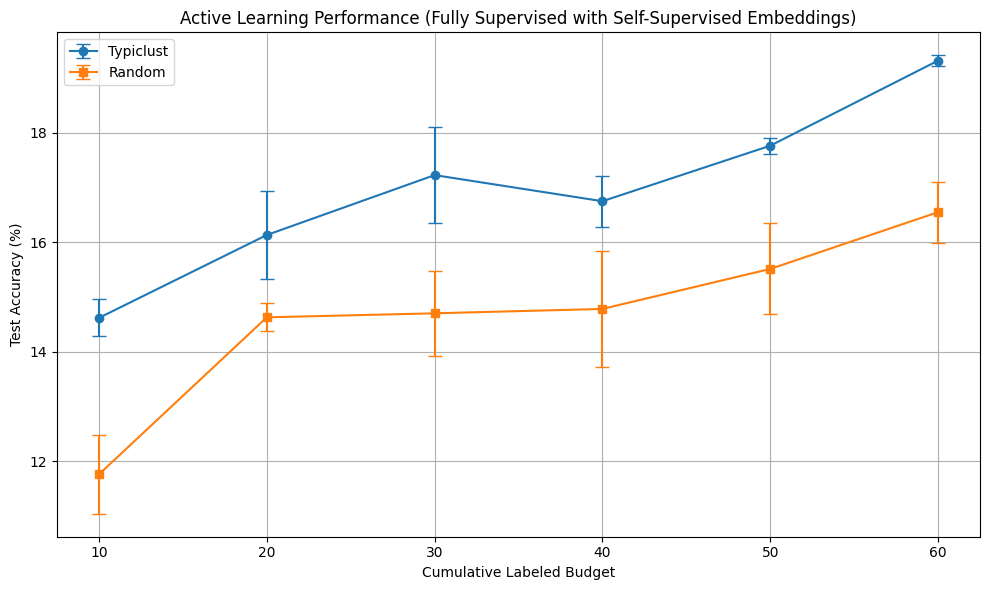

In [27]:

# Process and save results

typiclust_arr = np.array(all_results["typiclust"])
random_arr = np.array(all_results["random"])
hybrid_arr = np.array(all_results["hybrid"])

mean_tpcr = typiclust_arr.mean(axis=0)
se_tpcr = typiclust_arr.std(axis=0, ddof=1) / math.sqrt(n_runs)
mean_rand = random_arr.mean(axis=0)
se_rand = random_arr.std(axis=0, ddof=1) / math.sqrt(n_runs)
mean_hybrid = hybrid_arr.mean(axis=0)
se_hybrid = hybrid_arr.std(axis=0, ddof=1) / math.sqrt(n_runs)

np.savetxt(f"{results_dir}/typiclust_runs.csv", typiclust_arr, delimiter=",", fmt="%.4f")
np.savetxt(f"{results_dir}/random_runs.csv", random_arr, delimiter=",", fmt="%.4f")
np.savetxt(f"{results_dir}/hybrid_runs.csv", hybrid_arr, delimiter=",", fmt="%.4f")

with open(f"{results_dir}/summary.csv", "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Iteration", "Typiclust_Mean", "Typiclust_SE", "Random_Mean", "Random_SE", "Hybrid_Mean", "Hybrid_SE"])
    for i in range(num_iterations):
        writer.writerow([i + 1, mean_tpcr[i], se_tpcr[i], mean_rand[i], se_rand[i], mean_hybrid[i], se_hybrid[i]])

cumulative_budget = np.arange(1, num_iterations + 1) * budget_per_iter

plt.figure(figsize=(10, 6))
plt.errorbar(cumulative_budget, mean_tpcr * 100, yerr=se_tpcr * 100, fmt='-o', capsize=5, label="Typiclust")
plt.errorbar(cumulative_budget, mean_rand * 100, yerr=se_rand * 100, fmt='-s', capsize=5, label="Random")
plt.errorbar(cumulative_budget, mean_hybrid * 100, yerr=se_hybrid * 100, fmt='-^', capsize=5, label="Hybrid")

plt.xlabel("Cumulative Labeled Budget")
plt.ylabel("Test Accuracy (%)")
plt.title("Active Learning Performance (Fully Supervised with Self-Supervised Embeddings)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{results_dir}/performance_plot_cumulative_budget.png")
plt.show()

In [28]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Function to compute AUC using the trapezoidal rule.
def compute_auc(results, budget_per_iter):
    # results: numpy array of shape (n_runs, num_iterations)
    aucs = []
    for run in range(results.shape[0]):
        # Cumulative budget for each iteration
        budgets = np.arange(1, results.shape[1] + 1) * budget_per_iter
        auc = np.trapz(results[run], budgets)
        aucs.append(auc)
    return np.array(aucs)

# Calculate AUC for each method.
auc_typiclust = compute_auc(typiclust_arr, budget_per_iter)
auc_random = compute_auc(random_arr, budget_per_iter)
auc_hybrid = compute_auc(hybrid_arr, budget_per_iter)

print("AUC (Typiclust): {:.4f} ± {:.4f}".format(np.mean(auc_typiclust), np.std(auc_typiclust)))
print("AUC (Random): {:.4f} ± {:.4f}".format(np.mean(auc_random), np.std(auc_random)))
print("AUC (Hybrid): {:.4f} ± {:.4f}".format(np.mean(auc_hybrid), np.std(auc_hybrid)))

# Compare the final iteration accuracies across runs using paired t-tests.
# (Make sure that n_runs > 1 for these tests to be meaningful.)
final_iter_typiclust = typiclust_arr[:, -1]
final_iter_random = random_arr[:, -1]
final_iter_hybrid = hybrid_arr[:, -1]

t_stat, p_val = stats.ttest_rel(final_iter_typiclust, final_iter_random)
print("\nPaired t-test (Typiclust vs Random): t = {:.4f}, p = {:.4f}".format(t_stat, p_val))

t_stat, p_val = stats.ttest_rel(final_iter_typiclust, final_iter_hybrid)
print("Paired t-test (Typiclust vs Hybrid): t = {:.4f}, p = {:.4f}".format(t_stat, p_val))

t_stat, p_val = stats.ttest_rel(final_iter_random, final_iter_hybrid)
print("Paired t-test (Random vs Hybrid): t = {:.4f}, p = {:.4f}".format(t_stat, p_val))

# Perform a Friedman test across the three methods.
friedman_stat, friedman_p = stats.friedmanchisquare(final_iter_typiclust, final_iter_random, final_iter_hybrid)
print("\nFriedman test: statistic = {:.4f}, p = {:.4f}".format(friedman_stat, friedman_p))

# Save all statistics to a CSV
with open(f"{results_dir}/statistical_analysis.csv", "w", newline="") as f:
    writer = csv.writer(f)

    # AUC Results
    writer.writerow(["Metric", "Typiclust", "Random", "Hybrid"])
    writer.writerow(["AUC Mean", np.mean(auc_typiclust), np.mean(auc_random), np.mean(auc_hybrid)])
    writer.writerow(["AUC Std", np.std(auc_typiclust), np.std(auc_random), np.std(auc_hybrid)])
    writer.writerow([])

    # Paired t-tests
    writer.writerow(["Paired t-test Comparison", "t-statistic", "p-value"])
    writer.writerow(["Typiclust vs Random", stats.ttest_rel(final_iter_typiclust, final_iter_random).statistic,
                     stats.ttest_rel(final_iter_typiclust, final_iter_random).pvalue])
    writer.writerow(["Typiclust vs Hybrid", stats.ttest_rel(final_iter_typiclust, final_iter_hybrid).statistic,
                     stats.ttest_rel(final_iter_typiclust, final_iter_hybrid).pvalue])
    writer.writerow(["Random vs Hybrid", stats.ttest_rel(final_iter_random, final_iter_hybrid).statistic,
                     stats.ttest_rel(final_iter_random, final_iter_hybrid).pvalue])
    writer.writerow([])

    # Friedman Test
    writer.writerow(["Friedman Test", "Statistic", "p-value"])
    writer.writerow(["All Methods", friedman_stat, friedman_p])


AUC (Typiclust): 8.4842 ± 0.1220
AUC (Random): 7.3787 ± 0.3477
AUC (Hybrid): 17.0330 ± 0.3654

Paired t-test (Typiclust vs Random): t = 4.7470, p = 0.0416
Paired t-test (Typiclust vs Hybrid): t = -63.9552, p = 0.0002
Paired t-test (Random vs Hybrid): t = -29.3852, p = 0.0012

Friedman test: statistic = 6.0000, p = 0.0498


<ipython-input-28-73a207715183>:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(results[run], budgets)
